In [1]:
from astropy.coordinates import SkyCoord
from astroplan import FixedTarget
import astropy.units as u
from astropy.coordinates import EarthLocation
from pytz import timezone
from astroplan import Observer
from astropy.time import Time, TimeDelta
import numpy as np
import astropy.units as u
import seaborn as sns
sns.set(font="times",font_scale=1.5,style="ticks")
import pandas as pd
from astroplan.plots import plot_sky
from astroplan.plots import plot_airmass 
from astroplan.plots import plot_finder_image
from astropy.visualization import ZScaleInterval,ImageNormalize
import matplotlib as mpl
from astropy import wcs 
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

from astroplan import Observer, FixedTarget
from astropy.time import Time

from ipywidgets import interact

from astropy.table import Table

## 観測サイトの指定(@SALT)

In [2]:
salt = Observer.at_site("SALT")

## ターゲットリストの読み込み

In [5]:
target_list = "./2mass_catalog/table_irsa_catalog_search_results_tmp.csv"

### "ipywidgets" が使える場合

In [ ]:
tt = pd.read_csv(target_list,delimiter=",")
targets = [FixedTarget(coord=SkyCoord(ra=ra, dec=dec,unit=(u.deg, u.deg))) for ra, dec in zip(tt.ra,tt.dec)]
@interact(year='2023', month='08', day='11', hour='01', save_csv=False)
def func(year,month,day,hour,save_csv):
    time = Time(f"{year}-{month}-{day} {hour}:00") 
    fig = plt.figure(figsize=(6,6))
    plot_sky(targets,salt,time, style_kwargs={'marker':'.', 'alpha':0.3, 'color':'gray'})
    theta = np.arange(0,360)
    low_limit = [90-30]*len(theta) # limit
    high_limit = [90-80]*len(theta) # limit
    plt.plot(theta,low_limit,'.', color='C1', markersize=4, label='limit : 30°, 80°')
    plt.plot(theta,high_limit,'.', color='C1', markersize=2)
    plt.title(f"UTC , {year}-{month}-{day} {hour}:00",fontsize=18)
    plt.legend(bbox_to_anchor=(1.2, 1.1),shadow=True,fontsize=18)
    
    #show Observable Star
    altitude = (91 * u.deg - salt.altaz(time, targets).alt) * (1/u.deg) # from source code, 90以上が見えない
    index = np.where( (altitude<=90-30) & (altitude>=90-80))
    observable = []
    for i in range(len(index[0])):
        observable.append(tt.loc[index[0][i],["ra","dec","h_m"]])
        #observable.append(tt.loc[index[0][i],["ra","dec"]])
    observable_df = pd.DataFrame(observable,columns=["ra","dec","h_m"])
    observable_script = observable_df.drop("h_m",axis=1)

    # degree表記からhourangle表記に変換
    #df['RA'] = Angle(df['ra'], unit='deg').to_string(unit='hourangle', sep=':')
    #df['DEC'] = Angle(df['dec'], unit='deg').to_string(unit='hourangle', sep=':')

    targets2 = [FixedTarget(coord=SkyCoord(ra=ra2, dec=dec2,unit=(u.deg, u.deg)))
               for ra2, dec2 in zip(observable_df.ra,observable_df.dec)]
    plot_sky(targets2,salt,time, style_kwargs={'marker':'.', 'color':'C0'})

    if save_csv==True:
        observable_script.to_csv(f"./target_list/tpointscript_{year}{month}{day}T{hour}00.txt",index=True, header=False, index_label='id')
        observable_df.to_csv(f"./target_list/tpoint_{year}{month}{day}T{hour}00.txt",index=True, index_label='id')
    return observable_df

### "ipywidgets" が使えない場合

### 観測時刻の指定(UTC)

In [3]:
# 2023/08/11 3:00 (SAST)の場合
year='2023'
month='08'
day='11'
hour='01'

<PolarAxesSubplot:title={'center':'UTC , 2023-08-11 01:00'}>

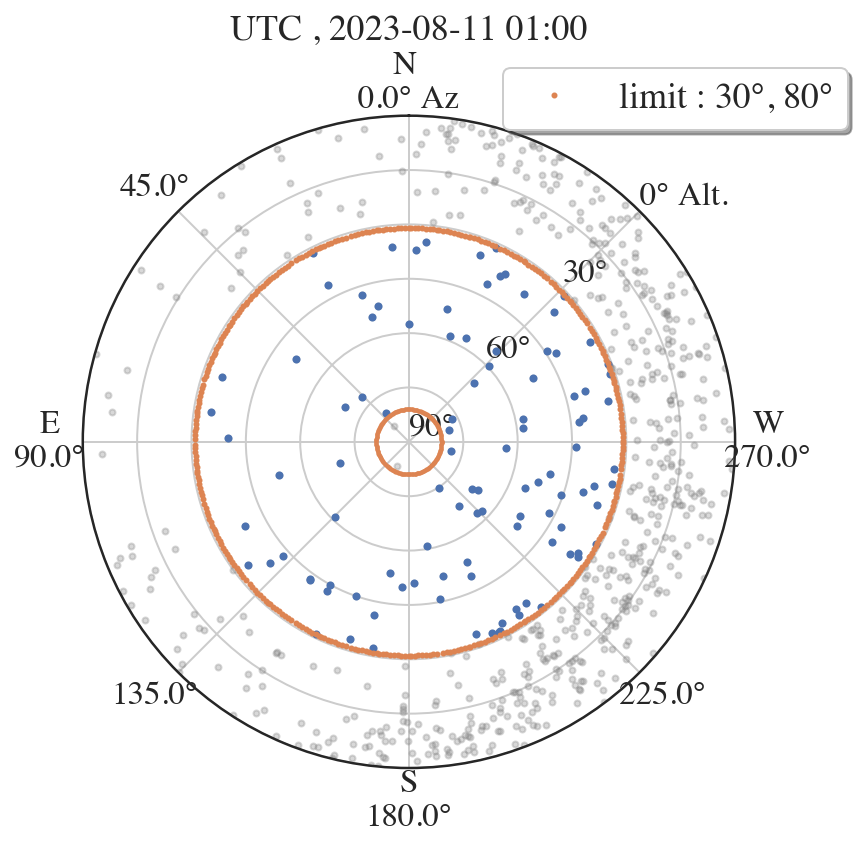

In [7]:
tt = pd.read_csv(target_list,delimiter=",")
targets = [FixedTarget(coord=SkyCoord(ra=ra, dec=dec,unit=(u.deg, u.deg))) for ra, dec in zip(tt.ra,tt.dec)]

time = Time(f"{year}-{month}-{day} {hour}:00") 
fig = plt.figure(figsize=(6,6))
plot_sky(targets,salt,time, style_kwargs={'marker':'.', 'alpha':0.3, 'color':'gray'})
theta = np.arange(0,360)
low_limit = [90-30]*len(theta) # limit
high_limit = [90-80]*len(theta) # limit
plt.plot(theta,low_limit,'.', color='C1', markersize=4, label='limit : 30°, 80°')
plt.plot(theta,high_limit,'.', color='C1', markersize=2)
plt.title(f"UTC , {year}-{month}-{day} {hour}:00",fontsize=18)
plt.legend(bbox_to_anchor=(1.2, 1.1),shadow=True,fontsize=18)

#show Observable Star
altitude = (91 * u.deg - salt.altaz(time, targets).alt) * (1/u.deg) # from source code, 90以上が見えない
index = np.where( (altitude<=90-30) & (altitude>=90-80))
observable = []
for i in range(len(index[0])):
    observable.append(tt.loc[index[0][i],["ra","dec","h_m"]])
    #observable.append(tt.loc[index[0][i],["ra","dec"]])
observable_df = pd.DataFrame(observable,columns=["ra","dec","h_m"])
observable_script = observable_df.drop("h_m",axis=1)

# degree表記からhourangle表記に変換
#df['RA'] = Angle(df['ra'], unit='deg').to_string(unit='hourangle', sep=':')
#df['DEC'] = Angle(df['dec'], unit='deg').to_string(unit='hourangle', sep=':')

targets2 = [FixedTarget(coord=SkyCoord(ra=ra2, dec=dec2,unit=(u.deg, u.deg)))
            for ra2, dec2 in zip(observable_df.ra,observable_df.dec)]
plot_sky(targets2,salt,time, style_kwargs={'marker':'.', 'color':'C0'})

#observable_script.to_csv(f"./target_list/tpointscript_{year}{month}{day}T{hour}00.txt",index=True, header=False, index_label='id')
#observable_df.to_csv(f"./target_list/tpoint_{year}{month}{day}T{hour}00.txt",index=True, index_label='id')